In [150]:

import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout, Input

tf.__version__

'2.0.0'

In [151]:
df = pd.read_csv('dowjone1985_2019.csv')

In [152]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1985-01-29,1277.719971,1295.489990,1266.890015,1292.619995,1292.619995,13560000
1,1985-01-30,1297.369995,1305.099976,1278.930054,1287.880005,1287.880005,16820000
2,1985-01-31,1283.239990,1293.400024,1272.640015,1286.770020,1286.770020,14070000
3,1985-02-01,1276.939941,1286.109985,1269.770020,1277.719971,1277.719971,10980000
4,1985-02-04,1272.079956,1294.939941,1268.989990,1290.079956,1290.079956,11630000


In [153]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,8762.000000,8762.000000,8762.000000,8762.000000,8762.000000,8.762000e+03
mean,9741.540516,9800.407341,9680.969127,9744.180560,9744.180560,1.387696e+08
std,6379.993445,6406.101221,6351.951044,6380.505213,6380.505213,1.218227e+08
min,1243.709961,1251.209961,1235.530029,1242.050049,1242.050049,2.530000e+06
25%,3614.900086,3635.000000,3595.430053,3616.775024,3616.775024,2.666250e+07
50%,9958.229981,10031.165039,9873.945312,9958.939942,9958.939942,1.047850e+08
75%,12604.689697,12672.895020,12536.984863,12608.264893,12608.264893,2.266075e+08
max,27364.689453,27398.679688,27294.169922,27359.160156,27359.160156,2.190810e+09


In [154]:
df = df.drop('Adj Close', axis=1)

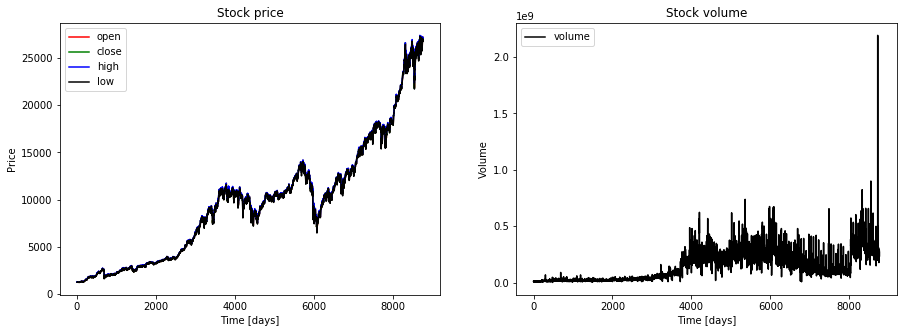

In [155]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(df['Open'], color='red', label='open')
plt.plot(df['Close'], color='green', label='close')
plt.plot(df['High'], color='blue', label='high')
plt.plot(df['Low'], color='black', label='low')
plt.title('Stock price')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')


plt.subplot(1, 2, 2)
plt.plot(df['Volume'], color='black', label='volume')
plt.title('Stock volume')
plt.xlabel('Time [days]')
plt.ylabel('Volume')
plt.legend(loc='best')

In [156]:
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df['Open'].to_numpy().reshape(-1, 1))
    df['Low'] = min_max_scaler.fit_transform(df['Low'].to_numpy().reshape(-1, 1))    
    df['High'] = min_max_scaler.fit_transform(df['High'].to_numpy().reshape(-1, 1))    
    df['Close'] = min_max_scaler.fit_transform(df['Close'].to_numpy().reshape(-1, 1))  
    #df['Volume'] = min_max_scaler.fit_transform(df['Volume'].to_numpy().reshape(-1, 1))  
    return df

def load_data(stock, seq_len):
    data_raw = stock.as_matrix()
    data = list()
    for index in range(len(data_raw) - seq_len):
        data.append(data_raw[index: index+seq_len])
    data = np.array(data)
    val_set_size = int(np.round(val_set_size_percentage/100*data.shape[0]))
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]))
    train_set_size = data.shape[0] - (val_set_size + test_set_size)
    
    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]
    
    x_val = data[train_set_size:train_set_size + val_set_size, :-1, :]
    y_val = data[train_set_size:train_set_size + val_set_size, -1, :]
    
    x_test = data[train_set_size+val_set_size:,:-1,:]
    y_test = data[train_set_size+val_set_size:,-1,:]
    
    return [x_train, y_train, x_val, y_val, x_test, y_test]

In [157]:
df_index = df.drop('Date', axis=1)
df_index = df_index.drop('Volume', axis=1)


cols = list(df_index.columns.values)
print('Col : ', cols)

# rearrange columns ,for training with volume
# n_cols = cols[:3] + [cols[-1]] + [cols[-2]]
# df_index = df_index[n_cols] 

# print("new Cols: ",list(df_index.columns.values))





# parameter for preprocessing #

val_set_size_percentage = 10
test_set_size_percentage = 10
seq_len = 20

#*****************************#

# normalize index
df_index_norm = normalize_data(df_index)

# split train, val, test data

x_train, y_train, x_val, y_val, x_test, y_test = load_data(df_index_norm, seq_len)

print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_val.shape = ', x_val.shape)
print('y_val.shape = ', y_val.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

Col :  ['Open', 'High', 'Low', 'Close']
x_train.shape =  (6994, 19, 4)
y_train.shape =  (6994, 4)
x_val.shape =  (874, 19, 4)
y_val.shape =  (874, 4)
x_test.shape =  (874, 19, 4)
y_test.shape =  (874, 4)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [158]:
print(y_train[0]); print(x_train[0]); 

[0.00124689 0.00160513 0.00141143 0.00168701]
[[0.00130202 0.00169347 0.00120344 0.00193628]
 [0.00205429 0.002061   0.00166548 0.00175479]
 [0.00151334 0.00161354 0.0014241  0.00171229]
 [0.00127216 0.00133474 0.00131396 0.00136577]
 [0.0010861  0.00167244 0.00128403 0.00183902]
 [0.00192757 0.00190917 0.00165281 0.00165332]
 [0.00157651 0.00165561 0.00151734 0.00147566]
 [0.00158072 0.00175275 0.00169925 0.00183902]
 [0.0017752  0.00175696 0.00175872 0.00183481]
 [0.00169519 0.00155006 0.00127136 0.00130221]
 [0.00105241 0.00122077 0.00118233 0.00132327]
 [0.00130623 0.00204418 0.00149586 0.00213921]
 [0.0022235  0.00215394 0.00184776 0.00175479]
 [0.00174151 0.0017233  0.00151734 0.00153041]
 [0.00138203 0.00138522 0.00145787 0.00147566]
 [0.00139505 0.0015795  0.00141987 0.00157291]
 [0.00140347 0.0013726  0.0014241  0.00141631]
 [0.00131044 0.00135157 0.0013224  0.00129378]
 [0.00100609 0.00122077 0.00108908 0.00135735]]


In [159]:
df_index.head(20)

,Open,High,Low,Close
0,0.001302,0.001693,0.001203,0.001936
1,0.002054,0.002061,0.001665,0.001755
2,0.001513,0.001614,0.001424,0.001712
3,0.001272,0.001335,0.001314,0.001366
4,0.001086,0.001672,0.001284,0.001839
5,0.001928,0.001909,0.001653,0.001653
6,0.001577,0.001656,0.001517,0.001476
7,0.001581,0.001753,0.001699,0.001839
8,0.001775,0.001757,0.001759,0.001835
9,0.001695,0.001550,0.001271,0.001302


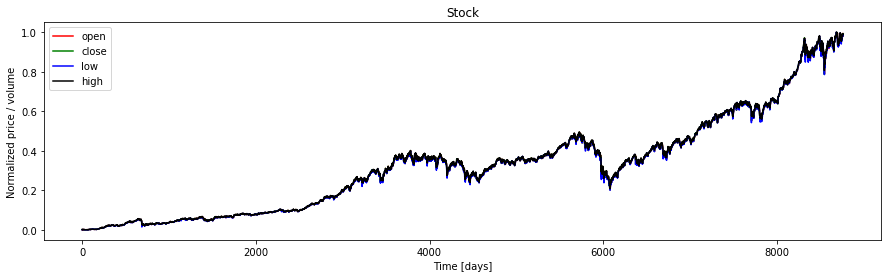

In [160]:
plt.figure(figsize=(15, 4))
plt.plot(df_index_norm['Open'], color='red', label='open')
plt.plot(df_index_norm['Close'], color='green', label='close')
plt.plot(df_index_norm['Low'], color='blue', label='low')
plt.plot(df_index_norm['High'], color='black', label='high')
plt.title('Stock')
plt.xlabel('Time [days]')
plt.ylabel('Normalized price / volume')
plt.legend(loc='best')
plt.show()

In [177]:
from tensorflow.keras import backend as K
K.clear_session()

In [178]:
from tensorflow.keras.layers import Bidirectional,TimeDistributed,BatchNormalization,Flatten
n_steps = seq_len - 1

def get_bi_gru():
    
    input1 = Input(shape=(19,4,))
    x = Bidirectional(LSTM(200,activation='relu', return_sequences=True))(input1)
    x = TimeDistributed(BatchNormalization())(x)
    x = LSTM(200,activation='relu')(x)
    #x = Dense(200,activation='relu')(x)
    x = (BatchNormalization())(x)
    out = Dense(4,activation='linear')(x)

    
    
    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(0.005),
                loss='mse',
                metrics=['mse'])   
    
    return model

In [179]:
model = get_bi_gru()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 19, 4)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 19, 400)           328000    
_________________________________________________________________
time_distributed (TimeDistri (None, 19, 400)           1600      
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               480800    
_________________________________________________________________
dense (Dense)                (None, 200)               40200     
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               800       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 804   

In [180]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
print('start training ')


# weight_path_model = "saved_model/model500ep_novolume.h5"
# callbacks_list_model = [
#     ModelCheckpoint(
#              weight_path_model,
#             save_best_only=True,
#             save_weights_only=True,
#             monitor='val_loss',
#             mode='min',
#             verbose=2
#         ),
#     ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, min_lr=0.0001)
# ]

#################
batch_size = 256
epochs = 500
#################

history = model.fit(x_train, y_train, epochs=epochs, verbose=2, callbacks=callbacks_list_model,
          validation_data=(x_val, y_val),batch_size=batch_size) #batch_size=batch_size




start training 
Train on 6994 samples, validate on 874 samples
Epoch 1/500

Epoch 00001: val_loss did not improve from 0.00003
6994/6994 - 12s - loss: 0.3782 - mse: 0.3782 - val_loss: 0.0921 - val_mse: 0.0921
Epoch 2/500

Epoch 00002: val_loss did not improve from 0.00003
6994/6994 - 9s - loss: 0.0158 - mse: 0.0158 - val_loss: 4.3008 - val_mse: 4.3008
Epoch 3/500

Epoch 00003: val_loss did not improve from 0.00003
6994/6994 - 10s - loss: 0.0054 - mse: 0.0054 - val_loss: 0.1672 - val_mse: 0.1672
Epoch 4/500

Epoch 00004: val_loss did not improve from 0.00003
6994/6994 - 10s - loss: 4.6950e-04 - mse: 4.6950e-04 - val_loss: 0.0314 - val_mse: 0.0314
Epoch 5/500

Epoch 00005: val_loss did not improve from 0.00003
6994/6994 - 9s - loss: 2.7398e-04 - mse: 2.7398e-04 - val_loss: 0.0183 - val_mse: 0.0183
Epoch 6/500

Epoch 00006: val_loss did not improve from 0.00003
6994/6994 - 9s - loss: 2.1372e-04 - mse: 2.1372e-04 - val_loss: 0.0170 - val_mse: 0.0170
Epoch 7/500

Epoch 00007: val_loss did n

Epoch 54/500

Epoch 00054: val_loss did not improve from 0.00003
6994/6994 - 9s - loss: 1.5728e-04 - mse: 1.5728e-04 - val_loss: 9.7787e-04 - val_mse: 9.7787e-04
Epoch 55/500

Epoch 00055: val_loss did not improve from 0.00003
6994/6994 - 9s - loss: 2.4361e-04 - mse: 2.4361e-04 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 56/500

Epoch 00056: val_loss did not improve from 0.00003
6994/6994 - 9s - loss: 1.7445e-04 - mse: 1.7445e-04 - val_loss: 6.0871e-04 - val_mse: 6.0871e-04
Epoch 57/500

Epoch 00057: val_loss did not improve from 0.00003
6994/6994 - 10s - loss: 1.8853e-04 - mse: 1.8853e-04 - val_loss: 8.2962e-04 - val_mse: 8.2962e-04
Epoch 58/500

Epoch 00058: val_loss did not improve from 0.00003
6994/6994 - 10s - loss: 1.4262e-04 - mse: 1.4262e-04 - val_loss: 4.2851e-04 - val_mse: 4.2851e-04
Epoch 59/500

Epoch 00059: val_loss did not improve from 0.00003
6994/6994 - 10s - loss: 1.6380e-04 - mse: 1.6380e-04 - val_loss: 5.9071e-04 - val_mse: 5.9071e-04
Epoch 60/500

Epoch 00060: val_lo

Epoch 105/500

Epoch 00105: val_loss did not improve from 0.00003
6994/6994 - 13s - loss: 9.7348e-05 - mse: 9.7348e-05 - val_loss: 6.3673e-05 - val_mse: 6.3673e-05
Epoch 106/500

Epoch 00106: val_loss did not improve from 0.00003
6994/6994 - 13s - loss: 1.1450e-04 - mse: 1.1450e-04 - val_loss: 4.5060e-04 - val_mse: 4.5060e-04
Epoch 107/500

Epoch 00107: val_loss did not improve from 0.00003
6994/6994 - 14s - loss: 1.3954e-04 - mse: 1.3954e-04 - val_loss: 5.7230e-05 - val_mse: 5.7230e-05
Epoch 108/500

Epoch 00108: val_loss did not improve from 0.00003
6994/6994 - 17s - loss: 1.4776e-04 - mse: 1.4776e-04 - val_loss: 3.2914e-04 - val_mse: 3.2914e-04
Epoch 109/500

Epoch 00109: val_loss did not improve from 0.00003
6994/6994 - 18s - loss: 1.0788e-04 - mse: 1.0788e-04 - val_loss: 2.0245e-04 - val_mse: 2.0245e-04
Epoch 110/500

Epoch 00110: val_loss did not improve from 0.00003
6994/6994 - 17s - loss: 1.2846e-04 - mse: 1.2846e-04 - val_loss: 1.8434e-04 - val_mse: 1.8434e-04
Epoch 111/500

E

Epoch 155/500

Epoch 00155: val_loss did not improve from 0.00003
6994/6994 - 17s - loss: 9.0607e-05 - mse: 9.0607e-05 - val_loss: 1.6638e-04 - val_mse: 1.6638e-04
Epoch 156/500

Epoch 00156: val_loss did not improve from 0.00003
6994/6994 - 16s - loss: 1.3261e-04 - mse: 1.3261e-04 - val_loss: 8.8826e-05 - val_mse: 8.8826e-05
Epoch 157/500

Epoch 00157: val_loss did not improve from 0.00003
6994/6994 - 16s - loss: 8.9989e-05 - mse: 8.9989e-05 - val_loss: 3.4650e-04 - val_mse: 3.4650e-04
Epoch 158/500

Epoch 00158: val_loss did not improve from 0.00003
6994/6994 - 15s - loss: 1.0424e-04 - mse: 1.0424e-04 - val_loss: 3.1673e-04 - val_mse: 3.1673e-04
Epoch 159/500

Epoch 00159: val_loss did not improve from 0.00003
6994/6994 - 15s - loss: 1.8553e-04 - mse: 1.8553e-04 - val_loss: 1.2063e-04 - val_mse: 1.2063e-04
Epoch 160/500

Epoch 00160: val_loss did not improve from 0.00003
6994/6994 - 16s - loss: 1.0881e-04 - mse: 1.0881e-04 - val_loss: 6.1810e-05 - val_mse: 6.1810e-05
Epoch 161/500

E

Epoch 205/500

Epoch 00205: val_loss did not improve from 0.00003
6994/6994 - 14s - loss: 1.1244e-04 - mse: 1.1244e-04 - val_loss: 9.5958e-05 - val_mse: 9.5958e-05
Epoch 206/500

Epoch 00206: val_loss did not improve from 0.00003
6994/6994 - 14s - loss: 9.1594e-05 - mse: 9.1594e-05 - val_loss: 3.2097e-04 - val_mse: 3.2097e-04
Epoch 207/500

Epoch 00207: val_loss did not improve from 0.00003
6994/6994 - 14s - loss: 8.9918e-05 - mse: 8.9918e-05 - val_loss: 2.8114e-04 - val_mse: 2.8114e-04
Epoch 208/500

Epoch 00208: val_loss did not improve from 0.00003
6994/6994 - 14s - loss: 1.4331e-04 - mse: 1.4331e-04 - val_loss: 6.5485e-04 - val_mse: 6.5485e-04
Epoch 209/500

Epoch 00209: val_loss did not improve from 0.00003
6994/6994 - 13s - loss: 1.1402e-04 - mse: 1.1402e-04 - val_loss: 3.7100e-04 - val_mse: 3.7100e-04
Epoch 210/500

Epoch 00210: val_loss did not improve from 0.00003
6994/6994 - 12s - loss: 1.2548e-04 - mse: 1.2548e-04 - val_loss: 1.0173e-04 - val_mse: 1.0173e-04
Epoch 211/500

E

Epoch 256/500

Epoch 00256: val_loss did not improve from 0.00003
6994/6994 - 10s - loss: 1.4370e-04 - mse: 1.4370e-04 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 257/500

Epoch 00257: val_loss did not improve from 0.00003
6994/6994 - 35s - loss: 1.3328e-04 - mse: 1.3328e-04 - val_loss: 5.7393e-04 - val_mse: 5.7393e-04
Epoch 258/500

Epoch 00258: val_loss did not improve from 0.00003
6994/6994 - 60s - loss: 8.7150e-05 - mse: 8.7150e-05 - val_loss: 9.1662e-04 - val_mse: 9.1662e-04
Epoch 259/500

Epoch 00259: val_loss did not improve from 0.00003
6994/6994 - 27s - loss: 1.1286e-04 - mse: 1.1286e-04 - val_loss: 2.2013e-04 - val_mse: 2.2013e-04
Epoch 260/500

Epoch 00260: val_loss did not improve from 0.00003
6994/6994 - 9s - loss: 1.3106e-04 - mse: 1.3106e-04 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 261/500

Epoch 00261: val_loss did not improve from 0.00003
6994/6994 - 9s - loss: 1.7494e-04 - mse: 1.7494e-04 - val_loss: 1.7801e-04 - val_mse: 1.7801e-04
Epoch 262/500

Epoch 00262: val_lo

Epoch 307/500

Epoch 00307: val_loss did not improve from 0.00003
6994/6994 - 10s - loss: 1.0192e-04 - mse: 1.0192e-04 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 308/500

Epoch 00308: val_loss did not improve from 0.00003
6994/6994 - 11s - loss: 1.0187e-04 - mse: 1.0187e-04 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 309/500

Epoch 00309: val_loss did not improve from 0.00003
6994/6994 - 11s - loss: 1.2028e-04 - mse: 1.2028e-04 - val_loss: 2.9864e-04 - val_mse: 2.9864e-04
Epoch 310/500

Epoch 00310: val_loss did not improve from 0.00003
6994/6994 - 12s - loss: 1.0897e-04 - mse: 1.0897e-04 - val_loss: 6.5366e-04 - val_mse: 6.5366e-04
Epoch 311/500

Epoch 00311: val_loss did not improve from 0.00003
6994/6994 - 14s - loss: 1.2535e-04 - mse: 1.2535e-04 - val_loss: 8.1137e-04 - val_mse: 8.1137e-04
Epoch 312/500

Epoch 00312: val_loss did not improve from 0.00003
6994/6994 - 13s - loss: 1.0901e-04 - mse: 1.0901e-04 - val_loss: 2.4482e-04 - val_mse: 2.4482e-04
Epoch 313/500

Epoch 00313: val_


Epoch 00358: val_loss did not improve from 0.00003
6994/6994 - 13s - loss: 8.9732e-05 - mse: 8.9732e-05 - val_loss: 6.6182e-04 - val_mse: 6.6182e-04
Epoch 359/500

Epoch 00359: val_loss did not improve from 0.00003
6994/6994 - 14s - loss: 1.2504e-04 - mse: 1.2504e-04 - val_loss: 0.0603 - val_mse: 0.0603
Epoch 360/500

Epoch 00360: val_loss did not improve from 0.00003
6994/6994 - 14s - loss: 8.4253e-05 - mse: 8.4253e-05 - val_loss: 0.0184 - val_mse: 0.0184
Epoch 361/500

Epoch 00361: val_loss did not improve from 0.00003
6994/6994 - 14s - loss: 1.3454e-04 - mse: 1.3454e-04 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 362/500

Epoch 00362: val_loss did not improve from 0.00003
6994/6994 - 16s - loss: 1.8671e-04 - mse: 1.8671e-04 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 363/500

Epoch 00363: val_loss did not improve from 0.00003
6994/6994 - 13s - loss: 1.9494e-04 - mse: 1.9494e-04 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 364/500

Epoch 00364: val_loss did not improve from 0.00003
6994

Epoch 410/500

Epoch 00410: val_loss did not improve from 0.00003
6994/6994 - 17s - loss: 9.9636e-05 - mse: 9.9636e-05 - val_loss: 0.0188 - val_mse: 0.0188
Epoch 411/500

Epoch 00411: val_loss did not improve from 0.00003
6994/6994 - 20s - loss: 1.2170e-04 - mse: 1.2170e-04 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 412/500

Epoch 00412: val_loss did not improve from 0.00003
6994/6994 - 16s - loss: 1.1218e-04 - mse: 1.1218e-04 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 413/500

Epoch 00413: val_loss did not improve from 0.00003
6994/6994 - 12s - loss: 1.3324e-04 - mse: 1.3324e-04 - val_loss: 3.1053e-04 - val_mse: 3.1053e-04
Epoch 414/500

Epoch 00414: val_loss did not improve from 0.00003
6994/6994 - 12s - loss: 1.4632e-04 - mse: 1.4632e-04 - val_loss: 4.0927e-04 - val_mse: 4.0927e-04
Epoch 415/500

Epoch 00415: val_loss did not improve from 0.00003
6994/6994 - 12s - loss: 1.1072e-04 - mse: 1.1072e-04 - val_loss: 6.5593e-04 - val_mse: 6.5593e-04
Epoch 416/500

Epoch 00416: val_loss did

Epoch 461/500

Epoch 00461: val_loss did not improve from 0.00003
6994/6994 - 16s - loss: 1.2085e-04 - mse: 1.2085e-04 - val_loss: 2.7210e-04 - val_mse: 2.7210e-04
Epoch 462/500

Epoch 00462: val_loss did not improve from 0.00003
6994/6994 - 16s - loss: 1.4991e-04 - mse: 1.4991e-04 - val_loss: 1.6970e-04 - val_mse: 1.6970e-04
Epoch 463/500

Epoch 00463: val_loss did not improve from 0.00003
6994/6994 - 16s - loss: 1.5737e-04 - mse: 1.5737e-04 - val_loss: 8.0949e-05 - val_mse: 8.0949e-05
Epoch 464/500

Epoch 00464: val_loss did not improve from 0.00003
6994/6994 - 15s - loss: 1.0246e-04 - mse: 1.0246e-04 - val_loss: 1.2362e-04 - val_mse: 1.2362e-04
Epoch 465/500

Epoch 00465: val_loss did not improve from 0.00003
6994/6994 - 13s - loss: 9.0397e-05 - mse: 9.0397e-05 - val_loss: 3.5804e-04 - val_mse: 3.5804e-04
Epoch 466/500

Epoch 00466: val_loss did not improve from 0.00003
6994/6994 - 14s - loss: 1.1250e-04 - mse: 1.1250e-04 - val_loss: 1.0738e-04 - val_mse: 1.0738e-04
Epoch 467/500

E

In [104]:
#model.save("saved_model/model00epVolume.h5")

In [125]:
#from tensorflow.keras.models import load_model
#model = load_model("saved_model/model500ep_novolume.h5")


ValueError: No model found in config file.

In [181]:
x_train.shape
y_train.shape

(6994, 4)

In [182]:
y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)
y_test_pred = model.predict(x_test)

In [183]:
print(y_test_pred[0])

[0.6335166  0.63670605 0.6287154  0.63445115]


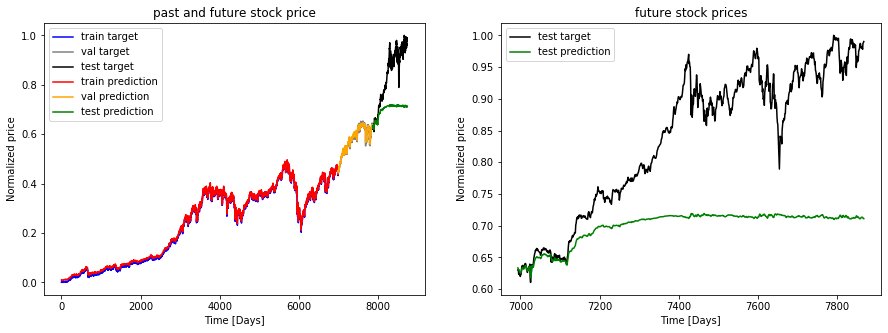

In [184]:
ft = 0
 
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

plt.plot(np.arange(y_train.shape[0]), y_train[:, ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_val.shape[0]), y_val[:, ft], 
         color='gray', label='val target')
plt.plot(np.arange(y_train.shape[0] + y_val.shape[0], y_train.shape[0] + y_val.shape[0] + y_test.shape[0]),
        y_test[:, ft], color='black', label='test target')
plt.plot(np.arange(y_train_pred.shape[0]), y_train_pred[:, ft],
        color='red', label='train prediction') 
plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0] + y_val_pred.shape[0]),
        y_val_pred[:, ft], color='orange', label='val prediction')
plt.plot(np.arange(y_train_pred.shape[0] + y_val_pred.shape[0],
        y_train_pred.shape[0] + y_val_pred.shape[0] + y_test_pred.shape[0]),
        y_test_pred[:, ft], color ='green', label='test prediction')
plt.title('past and future stock price')
plt.xlabel('Time [Days]')
plt.ylabel('Normalized price')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_test.shape[0]),
        y_test[:, ft], color='black', label='test target')
plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_test_pred.shape[0]),
        y_test_pred[:, ft], color='green', label='test prediction')
plt.title('future stock prices')
plt.xlabel('Time [Days]')
plt.ylabel('Normalized price')
plt.legend(loc='best')



In [136]:
evaluate(x_test,y_test)

NameError: name 'evaluate' is not defined